In [1]:
import os
os.chdir("../")
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [2]:
import torch
from gpytorch.kernels import RBFKernel, ScaleKernel, PeriodicKernel, MaternKernel, CosineKernel
from skgpytorch.models import SVGPRegressor, SGPRegressor
from scipy.stats import kurtosis,skew

In [3]:
import jax.numpy as jnp
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
# from utilities.fits import fit
import tensorflow_probability.substrates.jax as tfp
dist = tfp.distributions
import pandas as pd
import jax.numpy as jnp
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from gpytorch.constraints import GreaterThan
from skgpytorch.metrics import mean_squared_error, negative_log_predictive_density
import time
import numpy as np

# from datasets.dataset_load import dataset_loader
# from utilities import plot,fits,gmm,errors,predict,preprocess

# device = "cpu"
# torch.set_default_dtype(torch.float32)
# torch.set_default_tensor_type(torch.FloatTensor)


In [4]:
train ={1:{
            'start_time': "2011-04-28" ,
            'end_time': "2011-05-15"
        }, 
        3: {
        'start_time': "2011-04-19" ,
        'end_time': "2011-05-22"
        },
            
        }

test = {  2: {
                    'start_time': "2011-04-21" ,
                    'end_time': "2011-05-21"
                },
                }
appliances = ["Microwave", "Refrigerator",  "Dish Washer"] #

In [5]:
import pandas as pd
import jax.numpy as jnp
from datetime import datetime
from sklearn.preprocessing import StandardScaler


def dataset_load(appliances, train, test=None, bias=False):
    x_train = []
    y_train = []
    x_train_timestamp = []
    x_train_mean = []
    x_train_std = []
    x_train_max_min = []
    x_train_main = []
    x_train_main_dif = []
    x_train_max = []
    x_train_min = []
    x_train_kurtosis = []
    x_train_skew = []
    n = 99
    m = 9
    units_to_pad = n // 2
    units_to_pad1 = m//2
    scaler_x = StandardScaler()
    scaler_y = StandardScaler()
    scaler_time = StandardScaler()
    scaler_mean = StandardScaler()
    scaler_std = StandardScaler()
    scaler_max_min = StandardScaler()
    scaler_main = StandardScaler()
    scaler_diff = StandardScaler()
    scaler_max = StandardScaler()
    scaler_min = StandardScaler()
    scaler_kurtosis = StandardScaler()
    scaler_skew = StandardScaler()

    ## train
    for key, values in train.items():
        for app in range(len(appliances)):
            df = pd.read_csv(
                f"Data/Building{key}_NILM_data_basic.csv", usecols=["Timestamp", "main", appliances[app]])
            df["date"] = pd.to_datetime(df["Timestamp"]).dt.date
            startDate = datetime.strptime(values["start_time"], "%Y-%m-%d").date()
            endDate = datetime.strptime(values["end_time"], "%Y-%m-%d").date()

            if startDate > endDate:
                raise "Start Date must be smaller than Enddate."

            df = df[(df["date"] >= startDate) & (df["date"] <= endDate)]
            df.dropna(inplace=True)
            if app == 0:
                x = df[appliances[app]].values
            else:
                x += df[appliances[app]].values
            if appliances[app] == "Refrigerator":
                y = df[appliances[app]].values
        x_train_main.extend(x)
        timestamp_train = (pd.to_datetime(df["Timestamp"]).astype(int)/ 10**18).values
        x2 = x
        x = jnp.pad(x, (units_to_pad, units_to_pad),
                    'constant', constant_values=(0, 0))
        x = jnp.array([x[i: i + n] for i in range(len(x) - n + 1)])
        x_train_mean.extend(jnp.mean(x, axis=1))
        x_train_std.extend(jnp.std(x, axis=1))
        x1 = jnp.pad(x2, (units_to_pad1, units_to_pad1),
                    'constant', constant_values=(0, 0))
        x1 = jnp.array([x1[i: i + m] for i in range(len(x1) - m + 1)])
        x_train_max_min.extend(jnp.max(x, axis=1)-jnp.min(x,axis=1))
        x_train_max.extend(jnp.max(x1, axis = 1))
        x_train_min.extend(jnp.min(x1, axis = 1))
        x_train_kurtosis.extend(kurtosis(x,axis=1))
        x_train_skew.extend(skew(x,axis = 1))
        x_train.extend(x)
        y_train.extend(y)
        x_train_timestamp.extend(torch.tensor(timestamp_train))

    x_train = jnp.array(x_train)
    y_train = jnp.array(y_train).reshape(-1, 1)
    x_train_timestamp = torch.tensor(x_train_timestamp).reshape(-1,1)
    x_train_main = jnp.array(x_train_main).reshape(-1,1)
    x_train_mean = jnp.array(x_train_mean).reshape(-1,1)
    x_train_std =  jnp.array(x_train_std).reshape(-1,1)
    x_train_max_min =  jnp.array(x_train_max_min).reshape(-1,1)
    x_train_max =  jnp.array(x_train_max).reshape(-1,1)
    x_train_skew = jnp.array(x_train_skew).reshape(-1,1)
    x_train_min =  jnp.array(x_train_min).reshape(-1,1)
    x_train_kurtosis = jnp.array(x_train_kurtosis).reshape(-1,1)

    x_train = scaler_x.fit_transform(x_train)
    y_train = scaler_y.fit_transform(y_train)
    x_train_timestamp = scaler_time.fit_transform(x_train_timestamp)
    x_train_main = scaler_main.fit_transform(x_train_main)
    x_train_mean = scaler_mean.fit_transform(x_train_mean)
    x_train_std = scaler_std.fit_transform(x_train_std)
    x_train_max_min = scaler_max_min.fit_transform(x_train_max_min)
    x_train_max = scaler_max.fit_transform(x_train_max)
    x_train_min = scaler_min.fit_transform(x_train_min)
    x_train_kurtosis = scaler_kurtosis.fit_transform(x_train_kurtosis)
    x_train_skew = scaler_skew.fit_transform(x_train_skew)

    # test
    x_test = []
    y_test = []
    x_test_timestamp = []
    x_test_mean = []
    x_test_std = []
    x_test_max_min = []
    x_test_timestamp_true =[]
    x_test_main = []
    x_test_max = []
    x_test_min = []
    x_test_kurtosis = []
    x_test_skew = []

    for key, values in test.items():
        for app in range(len(appliances)):
            df = pd.read_csv(
                f"Data/Building{key}_NILM_data_basic.csv", usecols=["Timestamp", "main", appliances[app]])
            df["date"] = pd.to_datetime(df["Timestamp"]).dt.date
            startDate = datetime.strptime(values["start_time"], "%Y-%m-%d").date()
            endDate = datetime.strptime(values["end_time"], "%Y-%m-%d").date()

            if startDate > endDate:
                raise "Start Date must be smaller than Enddate."

            df = df[(df["date"] >= startDate) & (df["date"] <= endDate)]
            df.dropna(inplace=True)

            if app == 0:
                x = df[appliances[app]].values
            else:
                x += df[appliances[app]].values
            if appliances[app] == "Refrigerator":
                y = df[appliances[app]].values
         
        if (bias == True):
            x =  x + 100*np.ones(x.shape[0])

        x_test_main.extend(x)
        timestamp_true = df["Timestamp"].values
        timestamp = (pd.to_datetime(df["Timestamp"]).astype(int)/ 10**18).values
        x2 = x
        x = jnp.pad(x, (units_to_pad, units_to_pad),
                    'constant', constant_values=(0, 0))
        x = jnp.array([x[i: i + n] for i in range(len(x) - n + 1)])

        x_test_mean.extend(jnp.mean(x, axis=1))
        x_test_std.extend(jnp.std(x, axis=1))
        x1 = jnp.pad(x2, (units_to_pad1, units_to_pad1),
                    'constant', constant_values=(0, 0))
        x1 = jnp.array([x1[i: i + m] for i in range(len(x1) - m + 1)])
        x_test_max_min.extend(jnp.max(x, axis=1)-jnp.min(x, axis=1))
        x_test_max.extend(jnp.max(x1, axis=1))
        x_test_min.extend(jnp.min(x1, axis=1))
        x_test.extend(x)
        x_test_kurtosis.extend(kurtosis(x,axis=1))
        x_test_skew.extend(skew(x,axis=1))
        y_test.extend(y)
        x_test_timestamp_true.extend(timestamp_true)
        x_test_timestamp.extend(timestamp)

    x_test = jnp.array(x_test)
    y_test = jnp.array(y_test).reshape(-1, 1)
    x_test_timestamp = torch.tensor(x_test_timestamp).reshape(-1,1)
    x_test_main = jnp.array(x_test_main).reshape(-1,1)
    x_test_mean = jnp.array(x_test_mean).reshape(-1,1)
    x_test_std =  jnp.array(x_test_std).reshape(-1,1)
    x_test_max_min =  jnp.array(x_test_max_min).reshape(-1,1)
    x_test_max = jnp.array(x_test_max).reshape(-1,1)
    x_test_min = jnp.array(x_test_min).reshape(-1,1)
    x_test_kurtosis = jnp.array(x_test_kurtosis).reshape(-1,1)
    x_test_skew = jnp.array(x_test_skew).reshape(-1,1)

    x_test = scaler_x.transform(x_test)
    x_test_timestamp = scaler_time.transform(x_test_timestamp)
    x_test_mean = scaler_mean.transform(x_test_mean)
    x_test_std = scaler_std.transform(x_test_std)
    x_test_max_min = scaler_max_min.transform(x_test_max_min)
    x_test_main = scaler_main.transform(x_test_main)
    x_test_max =  scaler_max.transform(x_test_max)
    x_test_min = scaler_min.transform(x_test_min)
    x_test_kurtosis = scaler_kurtosis.transform(x_test_kurtosis)
    x_test_skew = scaler_skew.transform(x_test_skew)

    x_train = jnp.array(x_train[:,1:]).reshape(x_train.shape[0], n-1)
    y_train = jnp.array(y_train)
    x_train_timestamp = torch.tensor(x_train_timestamp).reshape(x_train_timestamp.shape[0], 1)
    x_test = jnp.array(x_test[:,1:]).reshape(x_test.shape[0], n-1)
    y_test = jnp.array(y_test)
    x_test_timestamp = torch.tensor(x_test_timestamp).reshape(x_test_timestamp.shape[0], 1).to(torch.float64)


    num_features_selected = 6
    x_train_features = jnp.concatenate((x_train_main, x_train_mean,  x_train_max_min,x_train_max, x_train_min, x_train_kurtosis), axis=1).reshape(x_train.shape[0], num_features_selected)
    x_test_features = jnp.concatenate((x_test_main, x_test_mean,  x_test_max_min, x_test_max, x_test_min,  x_test_kurtosis), axis=1).reshape(x_test.shape[0], num_features_selected)

    scalers = np.array([scaler_x, scaler_y, scaler_time, scaler_main, scaler_mean, scaler_std, scaler_max_min, scaler_max, scaler_min, scaler_kurtosis, scaler_skew])
    return x_train, y_train, x_test, y_test, x_train_features, x_test_features, x_train_timestamp, x_test_timestamp, scalers, x_test_main


In [6]:
x_train, y_train, x_test, y_test, x_train_features, x_test_features, x_train_timstamp, x_test_timestamp, scalers, x_test_main = dataset_load(appliances, train, test, bias=False)

In [15]:
x_train_diff = x_train_features[:,0]
# diff1 = np.array(x_train_diff)
# for i in range(1, len(x_train_diff)):
# 		value = x_train_diff[i] - x_train_diff[i - 1]
# 		diff1[i] = value

x_test_diff = x_test_features[:,0]
# diff2 = np.array(x_test_diff)
# for i in range(1, len(x_test_diff)):
# 		value = x_test_diff[i] - x_test_diff[i - 1]
# 		diff2[i] = value

In [16]:
x_train_features = jnp.concatenate((x_train_features, jnp.array(np.array(x_train_diff.reshape(-1,1)))), axis=1)
x_test_features = jnp.concatenate((x_test_features, jnp.array(np.array(x_test_diff.reshape(-1,1)))),  axis=1)

In [17]:
x_train_features.shape, x_test_features.shape

((24918, 7), (15656, 7))

In [18]:
n = x_train_features.shape[1]
x = torch.tensor(np.array(x_train_features)).to(torch.float64)
y = torch.tensor(np.array(y_train)).reshape(-1,).to(torch.float64)
xt = torch.tensor(np.array(x_test_features)).to(torch.float64)
yt = torch.tensor(np.array(y_test)).reshape(-1,).to(torch.float64)


In [19]:
x.shape, y.shape, xt.shape, yt.shape

(torch.Size([24918, 7]),
 torch.Size([24918]),
 torch.Size([15656, 7]),
 torch.Size([15656]))

In [20]:
from gpytorch.kernels import LinearKernel

In [ ]:
kernel1 = ScaleKernel(MaternKernel(nu=2.5, ard_num_dims=n))
kernel6 = ScaleKernel(LinearKernel(active_dims = (3)))
kernel = kernel1 #+ kernel6# + kernel6
inducing_points =  x[np.arange(0,x.shape[0],95)] 

model = SGPRegressor(x.to("cuda"), y.to("cuda"), kernel, 
                      inducing_points).to("cuda")
loss = model.fit(lr=0.01, n_epochs=1500,verbose=1,thetas = None,
        random_state=0, n_restarts=1)
plt.plot(np.asarray(loss[0]))

In [ ]:
model_name = "feature_final_min.pt"
torch.save(model.state_dict(), os.path.join(
  "/models", model_name))

In [21]:
kernel1 = ScaleKernel(MaternKernel(nu=2.5, ard_num_dims=n))
kernel2 = ScaleKernel(LinearKernel(active_dims = (2)))
kernel = kernel1 + kernel2
  # induce_points = 512
inducing_points =  x[np.arange(0,x.shape[0],95)]  # 95
  # inducing_points = x[torch.randperm(x.shape[0])[: 1500]]
  
model = SGPRegressor(x.to("cuda"), y.to("cuda"), kernel, 
                       inducing_points).to("cuda")
model_name =  "feature_final_linear.pt"
model.load_state_dict(torch.load(
    os.path.join("./models", model_name)))

<All keys matched successfully>

In [21]:
# kernel1 = ScaleKernel(MaternKernel(nu=2.5,ard_num_dims=n)) #nu=2.5,
# # kernel2 = ScaleKernel(RBFKernel(ard_num_dims=1, active_dims=(1)))
# # kernel3 = ScaleKernel(PeriodicKernel(ard_num_dims=1, active_dims=(1)))
# # kernel4 = ScaleKernel(PeriodicKernel(ard_num_dims=2, active_dims=(0)))
# # kernel5 = ScaleKernel(CosineKernel(ard_num_dims=2, active_dims=(1)))
# kernel2 = ScaleKernel(MaternKernel(nu=0.5,ard_num_dims=1,active_dims=(n-1)))
# kernel4 = ScaleKernel(PeriodicKernel(ard_num_dims=1, active_dims=(n-1)))
# kernel6 = ScaleKernel(LinearKernel(active_dims = (2)))

# kernel5 = kernel4 + kernel2
# kernel = kernel1 +kernel6 + kernel5
# # kernel = kernel1# + kernel2*kernel3
# # induce_points = 512
# inducing_points =  x[np.arange(0,x.shape[0],95)] 
# #x[torch.randperm(x.shape[0])[: batch]].to("cuda")

# model = SGPRegressor(x.to("cuda"), y.to("cuda"), kernel,
#                        inducing_points).to("cuda")

# model_name =  "features_linear.pt"
# model.load_state_dict(torch.load(
#     os.path.join("Neurips/models", model_name)))

## Scatter

In [14]:
x_lin_max = 3000
x_lin = np.linspace(0,x_lin_max,15656) #+ 100*np.ones(np.array(x_test).shape[0])
x_time = np.linspace(scalers[2].inverse_transform(x_test_timestamp.reshape(-1,1)).min(), scalers[2].inverse_transform(x_test_timestamp.reshape(-1,1)).max(), 15656)
x_range = np.linspace(scalers[6].inverse_transform(x_test_features[2].reshape(-1,1)).min(), scalers[6].inverse_transform(x_test_features[2].reshape(-1,1)).max(), 15656)
x_max = np.linspace(scalers[7].inverse_transform(x_test_features[3].reshape(-1,1)).min(), scalers[7].inverse_transform(x_test_features[3].reshape(-1,1)).max(), 15656)
x_min = np.linspace(scalers[8].inverse_transform(x_test_features[4].reshape(-1,1)).min(), scalers[8].inverse_transform(x_test_features[4].reshape(-1,1)).max(), 15656)
x_diff = np.linspace(scalers[3].inverse_transform(x_test_features[5].reshape(-1,1)).min(), scalers[3].inverse_transform(x_test_features[5].reshape(-1,1)).max(), 15656)
x_mean = np.linspace(scalers[4].inverse_transform(x_test_features[1].reshape(-1,1)).min(), scalers[4].inverse_transform(x_test_features[1].reshape(-1,1)).max(), 15656)
x_kur = np.linspace(scalers[9].inverse_transform(x_test_features[6].reshape(-1,1)).min(), scalers[9].inverse_transform(x_test_features[6].reshape(-1,1)).max(), 15656)

In [15]:
# x_train_diff = x_train_features[:,0]
# diff = np.array(x_train_diff)
# for i in range(1, len(x_train_diff)):
# 		value = x_train_diff[i] - x_train_diff[i - 1]
# 		diff[i] = value
x_lin_scale = torch.tensor(scalers[3].transform(x_lin.reshape(-1,1))).to(torch.float32)
x_lin_dif = x_lin_scale
diff_scale = np.array(x_lin_dif)
for i in range(1, len(x_lin_dif)):
		value = x_lin_dif[i] - x_lin_dif[i - 1]
		diff_scale[i] = value

		

In [16]:
x_range_scale = torch.tensor(diff_scale.reshape(-1,1)).to(torch.float32)

In [17]:

x_time_scale =  torch.tensor(scalers[2].transform(x_time.reshape(-1,1))).to(torch.float32)
# x_range_scale =  torch.tensor(scalers[6].transform(np.array().reshape(-1,1))).to(torch.float32)
x_max_scale =  torch.tensor(scalers[7].transform(x_max.reshape(-1,1))).to(torch.float32)
x_min_scale =  torch.tensor(scalers[8].transform(x_min.reshape(-1,1))).to(torch.float32)
x_dif_scale =  torch.tensor(scalers[3].transform(x_diff.reshape(-1,1))).to(torch.float32)
x_mean_scale =  torch.tensor(scalers[4].transform(x_mean.reshape(-1,1))).to(torch.float32)
x_kur_scale =  torch.tensor(scalers[9].transform(x_kur.reshape(-1,1))).to(torch.float32)

In [23]:
x_new = torch.cat((x_lin_scale, x_mean_scale, x_range_scale, x_max_scale,x_min_scale, x_kur_scale, x_dif_scale),dim=1 ).to(torch.float32)

In [24]:
x_new.shape, x_new.dtype

(torch.Size([15656, 7]), torch.float32)

In [25]:
pred_dist = model.predict(x_new.to("cuda"))

/home/desai.aadesh/miniconda3/envs/nlim/lib/python3.10/site-packages/gpytorch/kernels/inducing_point_kernel.py:61: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  /opt/conda/conda-bld/pytorch_1656352645774/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:2183.)
  inv_root = torch.triangular_solve(eye, chol)[0]


In [26]:
y_mean = pred_dist.loc 
y_mean = scalers[1].inverse_transform(y_mean.cpu().reshape(-1,1))

## Needed

In [27]:
try:
    from probml_utils import latexify, savefig, is_latexify_enabled
except ModuleNotFoundError:
    %pip install git+https://github.com/probml/probml-utils.git
    from probml_utils import latexify, savefig, is_latexify_enabled
os.environ["LATEXIFY"] = "1"
os.environ["FIG_DIR"] = "Neurips/FinalPlots/"

Text(0, 0.5, 'Train Appliance Power')

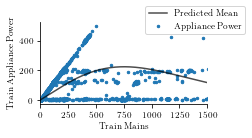

In [29]:
plt.figure()
latexify(width_scale_factor=2, fig_height=1.5)
start = 500
idx = 4000
plt.plot(x_lin, y_mean, 'k', label=" Predicted Mean", alpha=0.7)
plt.scatter( scalers[3].inverse_transform(x_train_features[:,0].reshape(-1,1)), scalers[1].inverse_transform(y_train.reshape(-1,1)), s = 6, label= "Appliance Power")
plt.xlim(00,1500)
sns.despine()
# plt.title("Train Mains Vs Train Applaince along with Predicted Means")
plt.legend( bbox_to_anchor=(0.6, 0.8))
plt.xlabel("Train Mains")
plt.ylabel("Train Appliance Power")
# plt.show()
# savefig("features_vs_app_mean")


saving image to Neurips/FinalPlots/mains_kde_latexified.pdf
Figure size: [2.4 1.5]


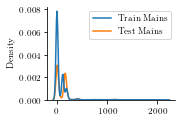

In [72]:
plt.figure()
latexify(width_scale_factor=2.5, fig_height=1.5)
sns.kdeplot(data = {"Train Mains":scalers[3].inverse_transform(x_train[:,49].reshape(-1,1)).squeeze(),"Test Mains":scalers[3].inverse_transform(x_test[:,49].reshape(-1,1)).squeeze() })
sns.despine()
# plt.xlim(500,2000)
# plt.ylim(0, 0.0001)
# savefig("mains_kde")

## Decomp

In [ ]:
kernel1 = ScaleKernel(RBFKernel(ard_num_dims=n))
# kernel2 = ScaleKernel(RBFKernel(ard_num_dims=1,active_dims=(99)))
# kernel3 = ScaleKernel(CosineKernel(ard_num_dims=1,active_dims=(99)))

# kernel4 = kernel2*kernel3
kernel = kernel1 #ernel4
# induce_points = 512
inducing_points =  x[np.arange(0,x.shape[0],70)] 
# inducing_points = x[torch.randperm(x.shape[0])[: 1500]]

model = SGPRegressor(x.to("cuda"), y.to("cuda"), kernel,
                      inducing_points).to("cuda")

model_name =  "Refrigerator_rbf_building6_" + str(0) + ".pt"
model.load_state_dict(torch.load(
    os.path.join("./final_models/", model_name)))

In [25]:
model1 = SGPRegressor(x.to("cuda"), y.to("cuda"), kernel1,
                      inducing_points).to("cuda")

In [26]:
pred_dist1 = model1.predict(xt.to("cuda"))
# print("Done ", i)

y_mean1 = pred_dist1.loc

In [27]:
pred_arr =[]
pred_arr.append(np.array(pred_dist1.mean.cpu()))

In [28]:
y_mean1 = np.mean(pred_arr, axis =0)

# y_Std = np.std(np.array(pred_arr), axis =0)

In [29]:
y_mean1 = scalers[1].inverse_transform(y_mean1.reshape(-1,1)).squeeze()
# y_std = scaler_y.inverse_transform(y_Std.reshape(-1,1)).squeeze()

In [33]:
y_mean1.shape

(15656,)

In [34]:
y_mean_1 = np.clip(y_mean1,0,y_mean1.max())
# y_sigma =  np.clip(y_mean,0,y_mean.max())

In [51]:
# x2 = x_train_features[:,0].reshape(-1,1)
# plt.figure()
# latexify(width_scale_factor=2, fig_height=1.75)
# df = pd.read_csv("time_stamp.csv", index_col=0)
# df.index = df["0"]
# df.index = pd.to_datetime(df.index)
# df.index.name = "Time"
# df[" Train Mains"] = scalers[3].inverse_transform(x2)
# df[start:start+idx].scatter(rot=90, legend=False)

In [22]:
time_plot = scalers[2].inverse_transform(x_test_timestamp.reshape(-1,1))
x1 = x_test_features[:,0].reshape(-1,1)

saving image to Neurips/FinalPlots/kernel1_decomp_linear_without bias_latexified.pdf
Figure size: [3.   1.75]


<Figure size 216x126 with 0 Axes>

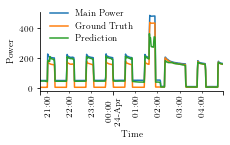

In [35]:
idx = 500 #x2.shape[0]
start = 4000

plt.figure()
latexify(width_scale_factor=2, fig_height=1.75)
df = pd.read_csv("time_stamp.csv", index_col=0)
df.index = df["0"]
df.index = pd.to_datetime(df.index)
df.index.name = "Time"
df = df.drop(columns=["0"])
df["Main Power"] = scalers[3].inverse_transform(x1)
df["Ground Truth"] = yt.cpu()
df["Prediction"] = y_mean_1
df[start:start+idx].plot(rot=90, legend=False)
sns.despine()
# df.plot.( rotation=90)
plt.legend(frameon=False, bbox_to_anchor=(0.55, 0.5))
# df.head()
# plt.ylim(0,350)
plt.ylabel("Power")
savefig("kernel1_decomp_linear_without bias")

In [29]:
# idx = 500
# latexify(width_scale_factor=2, fig_height=1.75)
# start = 4000
# plt.figure()
# plt.plot(x_test_timestamp[start: start + idx], scalers[3].inverse_transform(x_test_features[:,0].reshape(-1,1))[start : start+idx], label = "Main")
# plt.plot(x_test_timestamp[start:start+idx], yt.cpu()[start:start+idx], label = "Ground Truth")
# plt.plot(x_test_timestamp[start:start+idx], y_mean_[start:start+idx], label = "Predicted")
# # plt.legend(bbox_to_anchor=(1, 1),fontsize=20)
# plt.xlabel("Time")
# plt.ylabel("Power")
# sns.despine()
# plt.ylim(0,350)
# # savefig("kernel1_decomp_features_1")

In [15]:
model2 = SGPRegressor(x.to("cuda"), y.to("cuda"), kernel6,
                      inducing_points).to("cuda")

In [16]:
pred_dist2 = model2.predict(xt.to("cuda"))
# print("Done ", i)

y_mean2 = pred_dist2.loc

/home/desai.aadesh/miniconda3/envs/nlim/lib/python3.10/site-packages/gpytorch/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


In [17]:
y_mean2 = scalers[1].inverse_transform(y_mean2.cpu().reshape(-1,1)).squeeze()
# y_sigma = scaler_y.inverse_transform(y_sigma.reshape(-1,1)).squeeze()
print(yt.shape, y_mean2.shape)

torch.Size([15656]) (15656,)


In [18]:
y_mean_2 = np.clip(y_mean2,0,y_mean2.max())

In [34]:
# idx = 500
# latexify(width_scale_factor=2, fig_height=1.75)
# start = 4000
# plt.figure()
# plt.plot(x_test_timestamp[start: start + idx], scalers[3].inverse_transform(x_test_features[:,0].reshape(-1,1))[start : start+idx], label = "Main")
# plt.plot(x_test_timestamp[start:start+idx], yt.cpu()[start:start+idx], label = "Ground Truth")
# plt.plot(x_test_timestamp[start:start+idx], y_mean_[start:start+idx], label = "Predicted")
# # plt.legend(bbox_to_anchor=(1, 1),fontsize=20)
# plt.xlabel("Time")
# plt.ylabel("Power")
# plt.ylim(0,250)
# sns.despine()
# savefig("kernel2_decomp_features_2")

saving image to Neurips/FinalPlots/kernel2_decomp_linear_withoutbias_latexified.pdf
Figure size: [3.   1.75]


<Figure size 216x126 with 0 Axes>

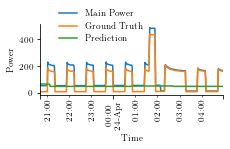

In [23]:
idx = 500 #x2.shape[0]
start = 4000

plt.figure()
latexify(width_scale_factor=2, fig_height=1.75)
df = pd.read_csv("time_stamp.csv", index_col=0)
df.index = df["0"]
df.index = pd.to_datetime(df.index)
df.index.name = "Time"
df = df.drop(columns=["0"])
df["Main Power"] = scalers[3].inverse_transform(x1)
df["Ground Truth"] = yt.cpu()
df["Prediction"] = y_mean_2
df[start:start+idx].plot(rot=90, legend=False)
sns.despine()
# df.plot.( rotation=90)
plt.legend(frameon=False, bbox_to_anchor=(0.6, 0.62))
# df.head()
# plt.ylim(0,350)
plt.ylabel("Power")
savefig("kernel2_decomp_linear_withoutbias")

In [ ]:
idx = 3000
# plt.figure(figsize=(10,6))
plt.plot(jnp.arange(idx),  yt.cpu().reshape(-1,1)[:idx], label = "Ground Truth", color="green")
plt.plot(jnp.arange(idx), y_mean_[:idx].reshape(-1,1), label = "Predicted")
# for i in range(2,3):
#     plt.fill_between(jnp.arange(idx), y_mean[:idx] - i*y_std[:idx], y_mean[:idx] + i*y_std[:idx],
#                     color="orange", alpha=(1/(i*3)), label=f"$\mu\pm{i}*\sigma$")
# plt.legend(bbox_to_anchor=(1, 1),fontsize=20)
plt.legend( prop={'size': 5.5})
plt.ylabel("Power")
sns.despine()

In [ ]:
mae = np.mean(np.abs(np.array(yt) - y_mean))
rms = errors.rmse(jnp.array(yt), y_mean)

print("MAE: ", mae)
print("RMSE: ", rms)

In [ ]:
try:
    from probml_utils import latexify, savefig, is_latexify_enabled
except ModuleNotFoundError:
    %pip install git+https://github.com/probml/probml-utils.git
    from probml_utils import latexify, savefig, is_latexify_enabled


In [ ]:
os.environ["LATEXIFY"] = "1"
os.environ["FIG_DIR"] = "./Final_plotss/"

In [ ]:
latexify(width_scale_factor=2, fig_height=2)

In [ ]:
idx = 2000
# plt.figure(figsize=(10,6))
plt.figure()
plt.plot(jnp.arange(idx), yt[300:idx+300], label = "Fridge True")
plt.plot(jnp.arange(idx), y_mean[300:idx+300], label = "Fridge Predicted")
plt.legend()
sns.despine()
savefig("CombinationKernel")

In [ ]:
model1 = SGPRegressor(x.to("cuda"), y.to("cuda"), kernel1,
                       inducing_points).to("cuda")

In [ ]:
pred_dist1 = model1.predict(xt.to("cuda"))
# print("Done ", i)

y_mean1 = pred_dist1.loc

In [ ]:
y_mean1 = scalers[1].inverse_transform(y_mean1.cpu().reshape(-1,1)).squeeze()
# y_sigma = scaler_y.inverse_transform(y_sigma.reshape(-1,1)).squeeze()
print(yt.shape, y_mean1.shape)

In [ ]:
idx = 2000
# plt.figure(figsize=(10,6))
plt.figure()
plt.plot(jnp.arange(idx), yt[300:idx+300], label = "Fridge True")
plt.plot(jnp.arange(idx), y_mean1[300:idx+300], label = "Fridge Predicted")
# plt.legend()
sns.despine()
savefig("RBFKernel")

In [ ]:
# for name, params in model.named_parameters():
#   print(name, params)

# # model.mll.model.base_covar_module.kernels.base_kernel.raw_lengthscale

In [ ]:
x.shape

In [ ]:
model2 = SGPRegressor(x.to("cuda"), y.to("cuda"), kernel4,
                       inducing_points).to("cuda")

In [ ]:
pred_dist2 = model2.predict(xt.to("cuda"))
# print("Done ", i)

y_mean2 = pred_dist2.loc

In [ ]:
y_mean2 = scaler_y.inverse_transform(y_mean2.cpu().reshape(-1,1)).squeeze()
# y_sigma = scaler_y.inverse_transform(y_sigma.reshape(-1,1)).squeeze()
print(yt.shape, y_mean2.shape)

In [ ]:
idx = 2000
plt.figure()
# plt.figure(figsize=(10,6))
plt.plot(jnp.arange(idx), yt[300:idx+300], label = "Fridge True")
plt.plot(jnp.arange(idx), y_mean2[300:idx+300], label = "Fridge Predicted")
# plt.legend()
sns.despine()
savefig("RBFxPeriodicKernel")

## Normal

In [ ]:
# kernel1 = ScaleKernel(MaternKernel(nu=2.5,ard_num_dims=n))
# # kernel2 = ScaleKernel(MaternKernel(nu=0.5,ard_num_dims=1,active_dims=(99)))
# # kernel3 = ScaleKernel(PeriodicKernel(ard_num_dims=1,active_dims=(99)))
# # # kernel5 = ScaleKernel(gpytorch.kernels.SpectralDeltaKernel(num_dims=n,ard_num_dims=n))
# # #   theta =  {'base_covar_module.kernels.0.base_kernel.lengthscale': torch.tensor(0.5),
# # #         'base_covar_module.kernels.0.outputscale': torch.tensor(5.0),
# # #         'base_covar_module.kernels.1.kernels.0.outputscale':torch.tensor(1.0),
# # #         'base_covar_module.kernels.1.kernels.0.base_kernel.lengthscale': torch.tensor(0.1),
# # #         'base_covar_module.kernels.1.kernels.1.outputscale':torch.tensor(1.0),
# # #         'base_covar_module.kernels.1.kernels.1.base_kernel.lengthscale': torch.tensor(1.0),
# # #         'base_covar_module.kernels.1.kernels.1.base_kernel.period_length': torch.tensor(0.01),}
# # #theta = { 'base_covar_module.kernels.1.kernels.1.base_kernel.period_length': torch.tensor(0.01),}
# # kernel4 = kernel2*kernel3
# kernel = kernel1 #+ kernel4
# inducing_points =  x[np.arange(0,x.shape[0],95)] 
# # inducing_points = x[torch.randperm(x.shape[0])[: 1500]]

# model = SGPRegressor(x.to("cuda"), y.to("cuda"), kernel,
#                       inducing_points).to("cuda")
# model_name = "Refrigerator_trial_seq_time.pt"
# # model_name =  "Refrigerator_trial_seq_time.pt"
# model.load_state_dict(torch.load(
#     os.path.join("models/", model_name)))

In [ ]:
# plt.scatter(range(x_train_features.shape[1]),model.mll.model.base_covar_module.base_kernel.lengthscale.cpu().detach().reshape(-1,1))

In [23]:
# fig, ax = plt.subplots(1,1) 
# latexify(width_scale_factor=3, fig_height=1.75)
# ax.bar(range(7),model.mll.model.base_covar_module.kernels[0].base_kernel.lengthscale.cpu().detach().reshape(-1,1)[:7])
# x_ticks_labels = ["Main", "Mean", "Range", "Max", "Min", "Kurtosis", "Difference"]
# sns.despine()
# # ax.set_xlabel("Number of features")
# ax.set_ylabel("LengthScale of features")
# # ax.set_xticklabels(x_ticks_labels, rotation='vertical')
# plt.xticks(range(len(x_ticks_labels)), x_ticks_labels,   rotation='vertical')
# plt.show()
# savefig("ARD_features")

In [ ]:
for name, params in model.named_parameters():
  print(name, params)

In [ ]:
# import numpy as np
# try:
#     from probml_utils import latexify, savefig, is_latexify_enabled
# except ModuleNotFoundError:
#     %pip install git+https://github.com/probml/probml-utils.git
#     from probml_utils import latexify, savefig, is_latexify_enabled


# os.environ["LATEXIFY"] = "1"
# os.environ["FIG_DIR"] = "./Final_plotss/"

# latexify(width_scale_factor=2, fig_height=2)


In [ ]:
# import seaborn as sns
# import matplotlib.pyplot as plt

In [ ]:
# arr = np.array([3.8464, 4.5094, 4.7394, 4.9024, 4.9117, 5.0150, 4.8746, 4.9372, 4.3143,
#          4.5656, 5.0050, 5.1365, 5.1490, 5.2152, 5.2837, 5.2594, 5.1965, 5.0747,
#          5.1212, 4.8200, 4.6431, 4.8732, 4.7529, 0.3853, 4.4826, 4.9550, 5.0677,
#          5.2859, 4.9612, 5.1401, 5.2131, 4.4774, 4.5654, 4.5685, 3.8310, 3.0889,
#          2.7822, 4.0948, 4.0399, 4.6180, 4.5923, 4.5015, 4.0521, 4.8423, 5.2143,
#          5.4020, 4.8021, 4.5021, 0.6626, 0.1252, 1.3779, 4.8821, 4.6781, 4.8554,
#          4.5223, 4.5568, 5.0172, 5.4072, 5.0706, 4.5916, 4.5663, 4.1121, 4.2572,
#          4.2228, 3.7784, 0.4839, 3.6554, 4.3523, 4.6682, 4.6549, 4.8291, 5.0260,
#          4.7748, 4.5609, 4.4541, 4.4165, 4.4292, 4.1279, 3.6382, 4.1110, 4.7252,
#          5.0184, 5.0391, 5.2424, 5.5062, 5.4739, 5.5326, 5.6874, 5.6897, 5.4765,
#          5.4602, 5.4513, 5.5450, 5.6225, 5.5479, 5.3580, 5.3926, 5.1536, 4.6321])
# ar1 = np.arange(0,99,1)
# plt.plot(ar1,arr,'b')
# plt.xlabel('ARD')
# plt.ylabel('Learned ARD LengthScale values')
# # plt.title("Building 6 Test")

# plt.show()
# sns.despine()
# savefig("ARD_Ref")


In [22]:
pred_dist = model.predict(xt.to("cuda"))
# print("Done ", i)/



/home/desai.aadesh/miniconda3/envs/nlim/lib/python3.10/site-packages/gpytorch/lazy/lazy_tensor.py:1810: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  /opt/conda/conda-bld/pytorch_1656352645774/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:2183.)
  Linv = torch.triangular_solve(Eye, L, upper=False).solution


In [23]:
y_mean = pred_dist.loc

In [24]:
y_mean = scalers[1].inverse_transform(y_mean.cpu().reshape(-1,1)).squeeze()
# y_sigma = scaler_y.inverse_transform(y_sigma.reshape(-1,1)).squeeze()
print(yt.shape, y_mean.shape)

torch.Size([15656]) (15656,)


In [25]:
y_mean = np.clip(y_mean,0,y_mean.max(),out=y_mean)

In [26]:
mae = torch.abs(torch.tensor(y_mean) - yt).mean(dim=-1)
mae

tensor(7.1367, dtype=torch.float64)

In [27]:
x2 =  x_test_features[:,1].reshape(-1,1)

In [28]:
from math import pi
var_pred = pred_dist.variance
var_pred = scalers[1].inverse_transform(var_pred.reshape(-1,1).detach().cpu()).squeeze()
# msll = mean_standardized_log_loss(torch.ensor(y_mean), yt)
f_var= torch.tensor(var_pred)
f_mean = torch.tensor(y_mean)
msll = 0.5 * (torch.log(2 * pi * f_var) + torch.square(yt - f_mean) / (2 * f_var)).mean(dim=-1)
msll

tensor(5.0274, dtype=torch.float64)

In [29]:
quantile = 95.0
standard_normal = torch.distributions.Normal(loc=0.0, scale=1.0)
deviation = standard_normal.icdf(torch.as_tensor(0.5 + 0.5 * (quantile / 100)))
std_pred = pred_dist.stddev
std_pred = torch.tensor(scalers[1].inverse_transform(std_pred.reshape(-1,1).detach().cpu()).squeeze())
lower = torch.tensor(y_mean) - deviation * std_pred 
upper = torch.tensor(y_mean) + deviation * std_pred 
n_samples_within_bounds = ((yt > lower) * (yt < upper)).sum(-1)
fraction = n_samples_within_bounds / yt.shape[-1]
qce = torch.abs(fraction - quantile / 100)
qce

tensor(0.0466)

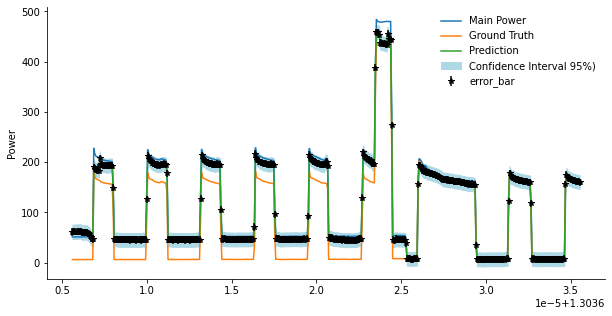

In [31]:
idx =500
x1 = x_test_features[:,0].reshape(-1,1)
fig, ax = plt.subplots(1,1, figsize=(10,5)) 
start = 4000
var_pred = pred_dist.variance
var_pred = scalers[1].inverse_transform(var_pred.reshape(-1,1).detach().cpu()).squeeze()
time_plot = scalers[2].inverse_transform(x_test_timestamp.cpu().reshape(-1,1))
# latexify(width_scale_factor=2, fig_height=1.75)
ax.plot(time_plot[start : start + idx], scalers[3].inverse_transform(x1)[start : start + idx], label = "Main Power")
ax.plot(time_plot[start : start + idx], yt.cpu()[start : start + idx], label = "Ground Truth")
ax.plot(time_plot[start : start + idx], y_mean[start : start + idx], label = "Prediction")
ax.fill_between(time_plot[start : start + idx].flatten(), y_mean[start : start + idx].flatten() - 1.96*np.sqrt(var_pred[start : start + idx]).flatten(),  y_mean[start : start + idx].flatten() + 1.96*np.sqrt(var_pred[start : start + idx]).flatten(),  color='lightblue', alpha=1.0, label = "Confidence Interval 95%)")
ax.errorbar(time_plot[start : start + idx].flatten(), y_mean[start : start + idx].flatten(), yerr=np.sqrt(var_pred[start : start + idx]).flatten(), fmt='k*', label = "error_bar")
plt.legend(frameon=False)
ax.set_ylabel("Power" )
sns.despine()
# plt.show()

In [ ]:
y_train1 = scalers[1].inverse_transform(y_train.reshape(-1,1))
idx = 1000
start = 0
x_train_plt = scalers[3].inverse_transform (x_train_features[:,0].reshape(-1,1))
plt.plot(x_train_timstamp[start : start + idx], x_train_plt[start : start + idx], label = "Main")
plt.plot(x_train_timstamp[start : start + idx], y_train1[start : start + idx], label = "Refri")
plt.legend()

In [ ]:
y_train1 = scalers[1].inverse_transform(y_train.reshape(-1,1))
print(y_train1.min())
plt.scatter(x_train_timstamp[:idx], y_train1[:idx], label = "Refri")

In [24]:
time_plot = scalers[2].inverse_transform(x_test_timestamp.reshape(-1,1))
x1 = x_test_features[:,0].reshape(-1,1)

In [22]:
try:
    from probml_utils import latexify, savefig, is_latexify_enabled
except ModuleNotFoundError:
    %pip install git+https://github.com/probml/probml-utils.git
    from probml_utils import latexify, savefig, is_latexify_enabled

os.environ["LATEXIFY"] = "1"
os.environ["FIG_DIR"] = "Neurips/FinalPlots/"

saving image to Neurips/FinalPlots/features_linear_1_latexified.pdf
Figure size: [3.   1.75]


<Figure size 216x126 with 0 Axes>

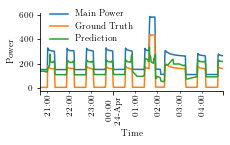

In [25]:
idx = 500 #x2.shape[0]
start = 4000

plt.figure()
latexify(width_scale_factor=2, fig_height=1.75)
df = pd.read_csv("time_stamp.csv", index_col=0)
df.index = df["0"]
df.index = pd.to_datetime(df.index)
df.index.name = "Time"
df = df.drop(columns=["0"])
df["Main Power"] = scalers[3].inverse_transform(x1)
df["Ground Truth"] = yt.cpu()
df["Prediction"] = y_mean
df[start:start+idx].plot(rot=90, legend=False)
sns.despine()
# df.plot.( rotation=90)
plt.legend(frameon=False, bbox_to_anchor=(0.55, 0.5))
# df.head()
plt.ylabel("Power")
savefig("features_linear_1")

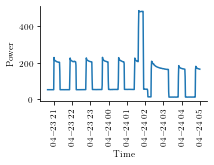

In [93]:
idx = 500 #x2.shape[0]
start = 4000
plt.figure() #figsize=(10,6)
latexify(width_scale_factor=2, fig_height=1.75)
plt.plot(df.index[start:start+idx], scalers[3].inverse_transform(x1)[start:start+idx], label = "Main")
# plt.plot(x_test_timestamp[:idx], scalers[-1].inverse_transform(x2)[:idx], label = "Main Ref Dif")
# plt.plot(time_plot[start:start+idx], yt.cpu()[start:start+idx], label = "Ground Truth")
# plt.plot(time_plot[start:start+idx], y_mean[start:start+idx], label = "Prediction")
# plt.legend(frameon=False, bbox_to_anchor=(0.6, 0.9))
plt.xlabel("Time")
plt.ylabel("Power")
# plt.title("Building 6")
plt.xticks(rotation=90)
sns.despine()
# savefig("Seq_to_point_main_features_added100_linear_plt1")

In [ ]:
# idx= 6000#yt.shape[0]
# start = 3000
mae_arr = np.abs(np.array(yt) - y_mean)
plt.plot(x_test_timestamp[start:start+idx],yt[start:start+idx], label = "ref ground truth")
plt.plot(x_test_timestamp[start:start+idx],mae_arr[start:start+idx], label="Eror")
plt.xlabel("TimeStamp")
plt.ylabel("Power and Error")
plt.legend()